## Declaring libraries and downloading dataset


In [22]:
import torch
import torchvision

import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR100
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

import torch.nn.functional as F
from torch.distributions import Gumbel

from torchsummary import summary

%matplotlib inline

In [2]:
dataset = CIFAR100(root = 'data/', download = True, transform = ToTensor())
test_dataset = CIFAR100(root = 'data/', train = False, transform = ToTensor())

100%|██████████| 169001437/169001437 [00:02<00:00, 83878792.53it/s]


Extracting data/cifar-100-python.tar.gz to data/


In [3]:
print(len(dataset))
print(len(test_dataset))

classes = dataset.classes 
print('Number of Classes:', len(classes))
print('Class Names :\n', classes)

#shape of the image tensor
img, label = dataset[31]
img_shape = img.shape
img_shape

50000
10000
Number of Classes: 100
Class Names :
 ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tul

torch.Size([3, 32, 32])

In [4]:
print("1 - Max & Min Pixel Values:", "Max:", torch.max(img), "Min:", torch.min(img))
print("2 - Pixel Values for all Channels:\n", img[:, 20:25, 20:25])

1 - Max & Min Pixel Values: Max: tensor(1.) Min: tensor(0.1020)
2 - Pixel Values for all Channels:
 tensor([[[0.5569, 0.6039, 0.6510, 0.6039, 0.8235],
         [0.3961, 0.5922, 0.7529, 0.6824, 0.8314],
         [0.2941, 0.5294, 0.6275, 0.6078, 0.6784],
         [0.3255, 0.4471, 0.4353, 0.4235, 0.4275],
         [0.4667, 0.4667, 0.5020, 0.5725, 0.4706]],

        [[0.4353, 0.4745, 0.5020, 0.4549, 0.6510],
         [0.3020, 0.4706, 0.5882, 0.5098, 0.6706],
         [0.2471, 0.4196, 0.4745, 0.4431, 0.5333],
         [0.2667, 0.3529, 0.3098, 0.2941, 0.3098],
         [0.3922, 0.4039, 0.4196, 0.4902, 0.3922]],

        [[0.4392, 0.4824, 0.5137, 0.4627, 0.6667],
         [0.3020, 0.4745, 0.6000, 0.5216, 0.6745],
         [0.2431, 0.4353, 0.4980, 0.4627, 0.5373],
         [0.2627, 0.3569, 0.3176, 0.2980, 0.3059],
         [0.3490, 0.3490, 0.3647, 0.4314, 0.3333]]])


## Preparing Dataset

In [5]:
torch.manual_seed(2718) ##settling a manual seed to get similar results everytime

val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset,[train_size, val_size])
len(train_ds), len(val_ds)

(40000, 10000)

In [6]:
batch_size = 128

In [7]:
# Defininf Loaders for training process
train_loader = DataLoader(train_ds, batch_size, shuffle = True, num_workers=4, pin_memory =True)
val_loader = DataLoader(val_ds, batch_size, num_workers=4, pin_memory =True)
test_loader = DataLoader(test_dataset, batch_size, num_workers=4, pin_memory =True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [8]:
torch.cuda.is_available()

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()
device
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

idk


In [9]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

## Using ResNet 9 structure to train the model

In [10]:
def drop_lowest_values(tensor):
    num_elements = tensor.numel()  # Total number of elements in the tensor
    num_values_to_drop = int(num_elements * 0.1)  # Number of values to drop (10% of total)
    
    if num_values_to_drop == 0:
        return tensor
    
    flattened_tensor = tensor.flatten()  # Flatten the tensor into a 1D tensor
    sorted_indices = torch.argsort(flattened_tensor)  # Sort the indices based on the tensor values
    
    # Set the lowest values to 0
    sorted_indices_to_drop = sorted_indices[:num_values_to_drop]
    flattened_tensor[sorted_indices_to_drop] = 0
    
    # Reshape the tensor back to its original shape
    dropped_tensor = flattened_tensor.reshape(tensor.shape)
    
    return dropped_tensor

In [11]:
class GumbleSoftmax(nn.Module):
    def __init__(self, temperature):
        super().__init__()
        self.temperature = temperature

    def forward(self, input):
        gumbel_noise = torch.rand_like(input)
        gumbel_noise = -torch.log(-torch.log(gumbel_noise + 1e-20) + 1e-20)
        logits = (input + gumbel_noise) / self.temperature
        return F.softmax(logits, dim=1)

In [ ]:
class LogGumbleSoftmax(nn.Module):
    def __init__(self, temperature):
        super().__init__()
        self.temperature = temperature

    def forward(self, input):
        gumbel_noise = torch.rand_like(input)
        gumbel_noise = -torch.log(-torch.log(gumbel_noise + 1e-20) + 1e-20)
        logits = (input + gumbel_noise) / self.temperature
        return F.log_softmax(logits, dim=1)

In [62]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Linear(512, num_classes),
                                        GumbleSoftmax(temperature = 1.2)
                                        )
        
        # self.softmax_layer = nn.LogSoftmax(dim = 1)
        # self.softmax_layer = nn.Softmax(dim = 1)

        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)

        # out = drop_lowest_values(out)

        # out = self.softmax_layer(out)

        return out

In [101]:
## Resnet12 Layer Structure

def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet12(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.conv5 = conv_block(512, 1024, pool=True)
        self.res3 = nn.Sequential(conv_block(1024, 1024), conv_block(1024, 1024))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(2), 
                                        nn.Flatten(), 
                                        nn.Linear(1024, num_classes),
                                        # GumbleSoftmax(temperature = 1.2)
                                        )
        
        self.softmax_layer = nn.LogSoftmax(dim = 1)
        # self.softmax_layer = nn.Softmax(dim = 1)
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.conv5(out)
        out = self.res3(out) + out
        out = self.classifier(out)

        
        # out = drop_lowest_values(out)

        out = self.softmax_layer(out)

        return out

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
 # for evaluation thingie

In [102]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    
     # After completing training, evaluate on the validation set
    model.eval()
    predicted_labels = []
    true_labels = []
    for batch in val_loader:
        outputs = model(batch[0])
        predicted_labels.extend(torch.argmax(outputs, dim=1).tolist())
        true_labels.extend(batch[1].tolist())

    precision = precision_score(true_labels, predicted_labels, average='macro')
    recall = recall_score(true_labels, predicted_labels, average='macro')
    f1 = f1_score(true_labels, predicted_labels, average='macro')
    cm = confusion_matrix(true_labels, predicted_labels)

    history[-1]['precision'] = precision
    history[-1]['recall'] = recall
    history[-1]['f1'] = f1
    history[-1]['confusion_matrix'] = cm

    return history

In [103]:
model_resnet12 = to_device(ResNet12(3, 100), device)
model_resnet12

ResNet12(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=T

In [104]:
summary(model_resnet12, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,856
       BatchNorm2d-5          [-1, 128, 32, 32]             256
              ReLU-6          [-1, 128, 32, 32]               0
         MaxPool2d-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

In [105]:
history_resnet12 = [evaluate(model_resnet12, val_loader)]
history_resnet12

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[{'val_loss': 4.605314254760742, 'val_acc': 0.009592562913894653}]

In [ ]:
model_resnet9 = to_device(ResNet9(3, 100), device)
model_resnet9

In [ ]:
history_resnet9 = [evaluate(model_resnet9, val_loader)]
history_resnet9

**Setting parameters for training**

In [106]:
epochs_resnet12 = 50
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-5
opt_func = torch.optim.Adam

In [107]:
%%time
history_resnet12 += fit_one_cycle(epochs_resnet12, max_lr, model_resnet12, train_loader, val_loader, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)


Epoch [0], last_lr: 0.00050, train_loss: 3.4846, val_loss: 3.1565, val_acc: 0.2355
Epoch [1], last_lr: 0.00081, train_loss: 2.4894, val_loss: 2.8322, val_acc: 0.3174
Epoch [2], last_lr: 0.00132, train_loss: 2.0702, val_loss: 2.3264, val_acc: 0.3981
Epoch [3], last_lr: 0.00199, train_loss: 1.7771, val_loss: 2.7028, val_acc: 0.3871
Epoch [4], last_lr: 0.00280, train_loss: 1.5644, val_loss: 2.5323, val_acc: 0.3941
Epoch [5], last_lr: 0.00371, train_loss: 1.2820, val_loss: 2.5919, val_acc: 0.4058
Epoch [6], last_lr: 0.00470, train_loss: 0.9935, val_loss: 2.1422, val_acc: 0.4675
Epoch [7], last_lr: 0.00570, train_loss: 0.7614, val_loss: 2.0738, val_acc: 0.4909
Epoch [8], last_lr: 0.00668, train_loss: 0.5972, val_loss: 2.4032, val_acc: 0.4476
Epoch [9], last_lr: 0.00760, train_loss: 0.5588, val_loss: 2.5987, val_acc: 0.4335
Epoch [10], last_lr: 0.00841, train_loss: 0.4864, val_loss: 2.5384, val_acc: 0.4780
Epoch [11], last_lr: 0.00908, train_loss: 0.4627, val_loss: 2.5913, val_acc: 0.4508
Ep

In [67]:
epochs_resnet9 = 50
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-5
opt_func = torch.optim.Adam

In [68]:
%%time
history_resnet9 += fit_one_cycle(epochs_resnet9, max_lr, model_resnet9, train_loader, val_loader, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00050, train_loss: 4.5897, val_loss: 4.5865, val_acc: 0.0349
Epoch [1], last_lr: 0.00081, train_loss: 4.5771, val_loss: 4.5729, val_acc: 0.0488
Epoch [2], last_lr: 0.00132, train_loss: 4.5700, val_loss: 4.5710, val_acc: 0.0504
Epoch [3], last_lr: 0.00199, train_loss: 4.5724, val_loss: 4.5784, val_acc: 0.0429
Epoch [4], last_lr: 0.00280, train_loss: 4.5697, val_loss: 4.5742, val_acc: 0.0472
Epoch [5], last_lr: 0.00371, train_loss: 4.5743, val_loss: 4.5931, val_acc: 0.0291
Epoch [6], last_lr: 0.00470, train_loss: 4.5786, val_loss: 4.5955, val_acc: 0.0267
Epoch [7], last_lr: 0.00570, train_loss: 4.5964, val_loss: 4.6029, val_acc: 0.0192
Epoch [8], last_lr: 0.00668, train_loss: 4.6012, val_loss: 4.6086, val_acc: 0.0117
Epoch [9], last_lr: 0.00760, train_loss: 4.6062, val_loss: 4.6059, val_acc: 0.0161
Epoch [10], last_lr: 0.00841, train_loss: 4.6060, val_loss: 4.6062, val_acc: 0.0136
Epoch [11], last_lr: 0.00908, train_loss: 4.6012, val_loss: 4.6034, val_acc: 0.0181
Ep

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Evaluating

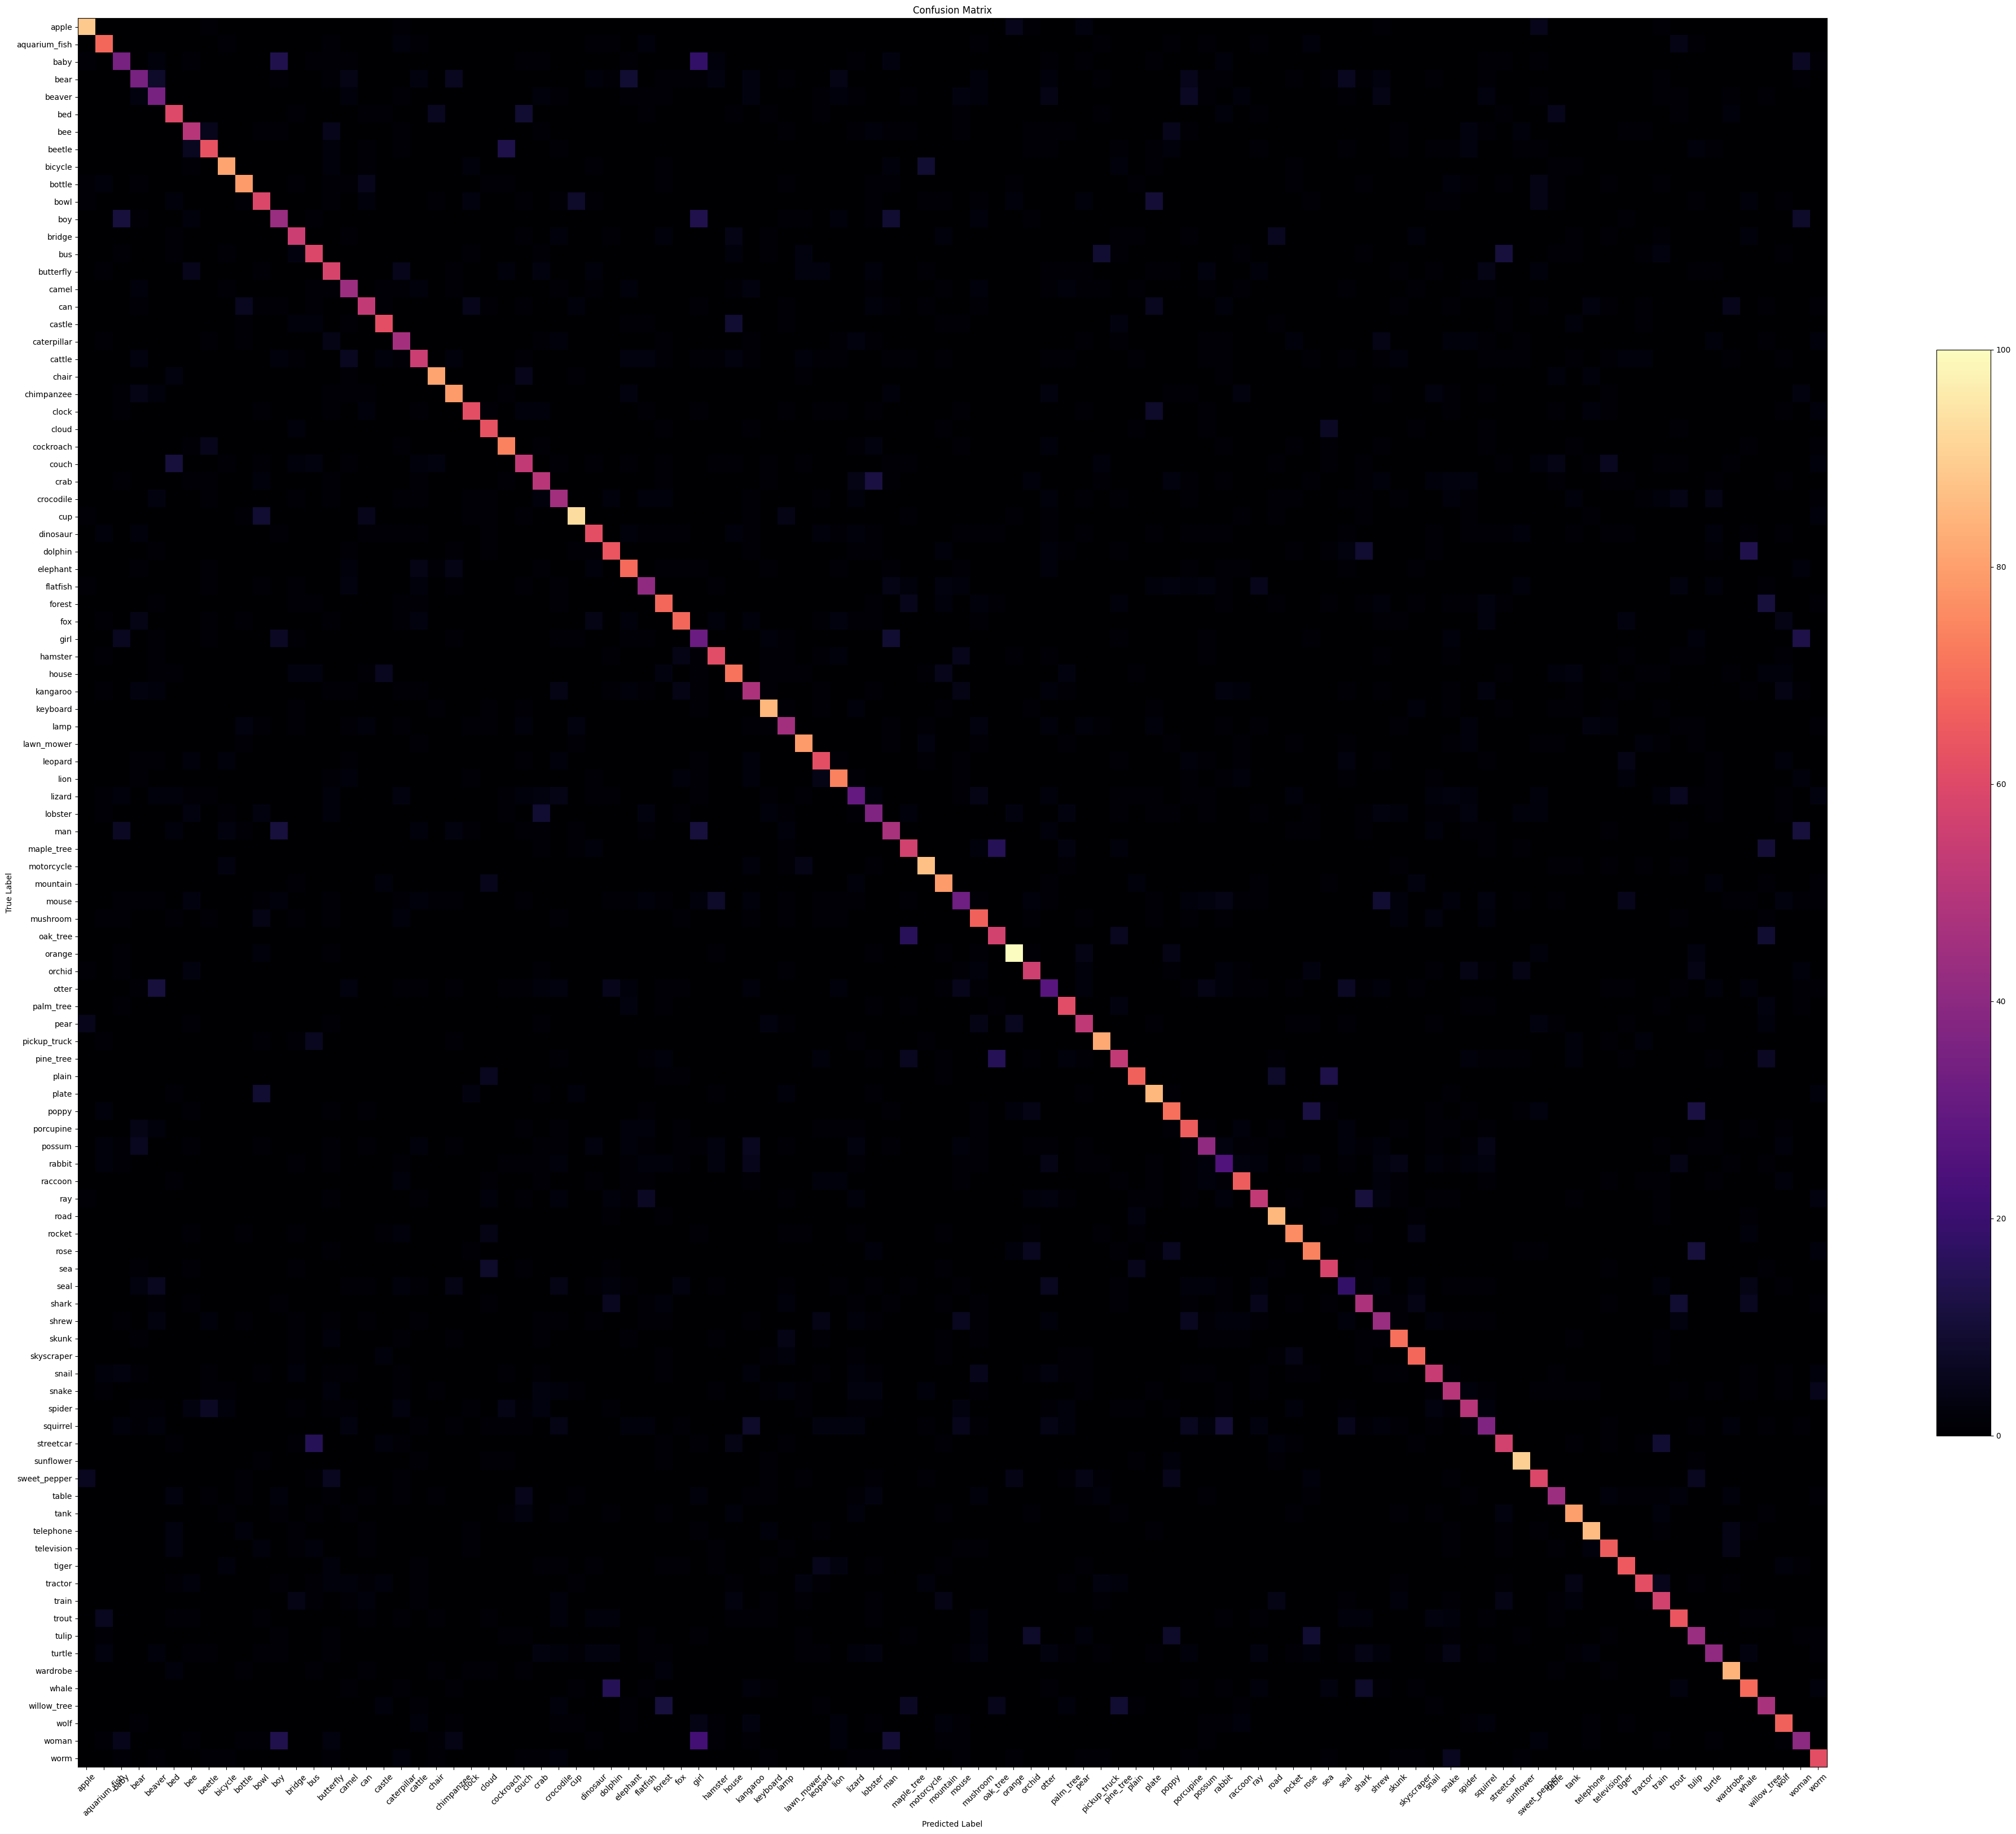

In [108]:
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(50, 50))
    # plt.imshow(cm, interpolation='nearest', cmap=plt.cm.OrRd)
    plt.imshow(cm, interpolation='nearest', cmap=plt.colormaps['magma'])

    ## https://matplotlib.org/stable/tutorials/colors/colormaps.html#lightness-of-matplotlib-colormaps

    plt.colorbar(shrink=0.50)
    
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

last_result = history_resnet12[-1]
cm = last_result['confusion_matrix']
plot_confusion_matrix(cm, classes)

In [109]:
last_result = history_resnet12[-1]
precision = last_result['precision']
recall = last_result['recall']
f1 = last_result['f1']

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Precision: 0.5922
Recall: 0.5987
F1 Score: 0.5931


In [110]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-o', color = 'black')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Number of Epochs');

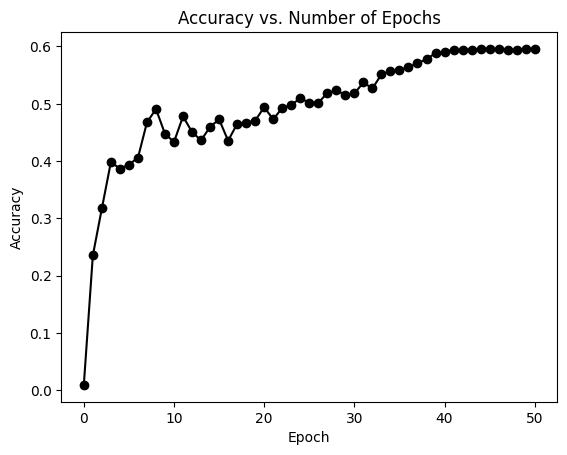

In [111]:
plot_accuracies(history_resnet12)

In [112]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, color = 'green')
    plt.plot(val_losses, color = 'brown')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. Number of epochs');

<ipython-input-97-3d3a6d9e4957>:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(train_losses, '-bo', color = 'green')
<ipython-input-97-3d3a6d9e4957>:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(val_losses, '-ro', color = 'brown')


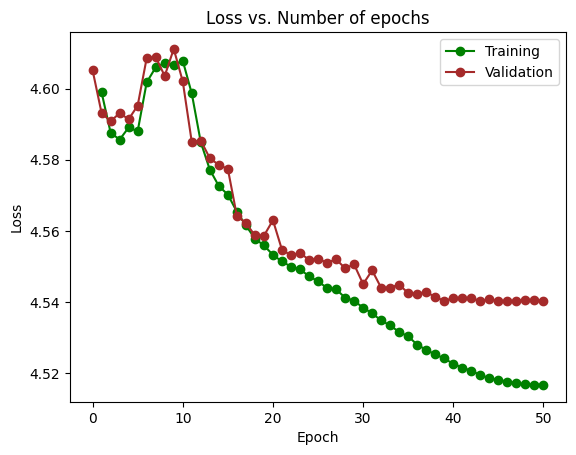

In [98]:
plot_losses(history_resnet12)

In [113]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs, color = 'orange')
    plt.xlabel('Batch Number')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate vs. Batch Number');

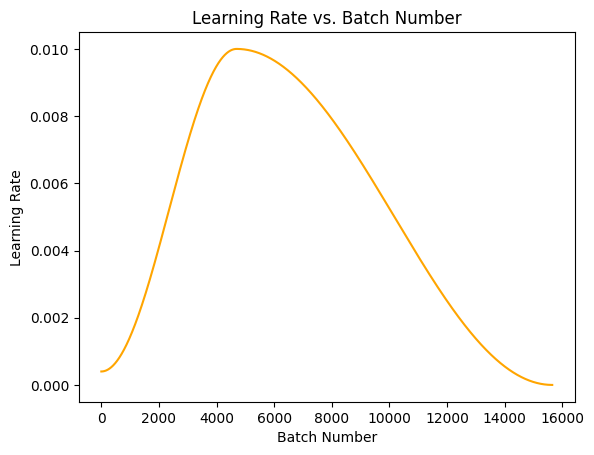

In [114]:
plot_lrs(history_resnet12)

In [115]:
test_resnet12 = evaluate(model_resnet12, test_loader) #final evaluation of resnet9 model with test dataset
test_resnet12

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'val_loss': 2.613736867904663, 'val_acc': 0.6015625}

In [116]:
test_loss_resnet12 = test_resnet12['val_loss']
test_acc_resnet12 = test_resnet12['val_acc']
print('test_loss_resnet9:', test_resnet12['val_loss'])
print('test_acc_resnet9:', test_resnet12['val_acc'])

test_loss_resnet9: 2.613736867904663
test_acc_resnet9: 0.6015625


In [117]:
torch.save(model_resnet12.state_dict(), 'ResNet12_v1_log_softmax.pth')

In [79]:
def predict_image(img, model_resnet12):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model_resnet9(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)

    print(yb)
    # Retrieve the class label
    # return yb

    return dataset.classes[preds[0].item()]

In [81]:
# import torch.nn.functional as F

# def predict_image(img, model_resnet9):
#     # Convert to a batch of 1
#     xb = to_device(img.unsqueeze(0), device)
#     # Get predictions from model
#     yb = model_resnet9(xb)
#     # Apply softmax to convert to probabilities
#     probs = F.log_softmax(yb, dim=1)
#     # Pick index with highest probability
#     _, preds = torch.max(probs, dim=1)
#     # Retrieve the class label
#     print(probs)
#     print(preds.shape)
#     # return probs
#     predicted_label = dataset.classes[preds[0].item()]
#     return predicted_label


tensor([[4.7874e-11, 4.7423e-11, 4.9257e-11, 5.1479e-11, 5.3838e-11, 5.4529e-11,
         4.9286e-11, 4.6904e-11, 5.2874e-11, 4.9970e-11, 5.0722e-11, 4.8717e-11,
         4.8018e-11, 4.6937e-11, 4.7200e-11, 5.0246e-11, 4.9087e-11, 8.2994e-09,
         5.2349e-11, 4.6532e-11, 3.4985e-14, 5.2051e-11, 4.7807e-11, 4.2561e-13,
         4.7291e-11, 5.3582e-11, 4.8272e-11, 5.3258e-11, 5.0350e-11, 4.7374e-11,
         6.0808e-11, 1.2838e-01, 4.9998e-11, 5.1515e-11, 4.7950e-11, 4.9122e-11,
         5.1657e-11, 4.6859e-11, 8.7079e-01, 5.1642e-11, 4.8609e-11, 4.9533e-11,
         3.3038e-09, 4.9337e-11, 5.0405e-11, 4.8981e-11, 4.8603e-11, 5.3277e-11,
         4.7087e-11, 4.6502e-11, 5.1276e-11, 4.8496e-11, 4.5985e-11, 4.5429e-11,
         5.0233e-11, 5.1589e-11, 4.6876e-11, 4.8313e-11, 4.6419e-11, 4.7037e-11,
         4.5667e-11, 1.3082e-15, 1.7517e-07, 5.5900e-11, 4.9533e-11, 5.0725e-11,
         9.7905e-05, 5.2585e-11, 4.7432e-11, 4.6682e-11, 4.7018e-11, 4.7205e-11,
         5.5154e-11, 4.7811e

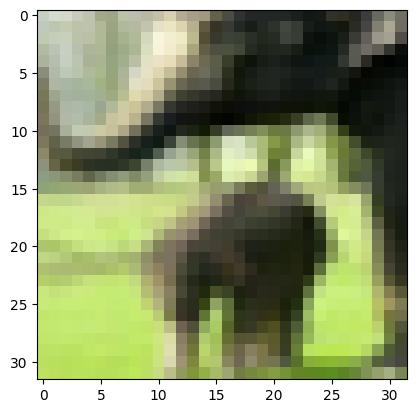

In [82]:
img, label = test_dataset[3480]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model_resnet12))